In [1]:
!pip install einops
!pip install denoising_diffusion_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.1/819.1 kB 49.6 MB/s eta 0:00:00


In [1]:
from diffusion import VPSDE
import torchvision
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
from denoising_diffusion_pytorch import Unet
from diffusion import VPSDE
from torch.utils.data import DataLoader
from torch.optim import Adam
from training import train_score_network_mnist
import torch
from guided_diffusion import Net

In [2]:
device = 'cuda'
data = 'MNIST'
model = Unet(channels = 1, dim = 32).to(device)
model.load_state_dict(torch.load('./epoch49'))
sde = VPSDE(100, 0.1, 20, device = device)

''' hyper params'''
n_epochs =   50
batch_size =  32
lr=1e-4
optimizer = Adam(model.parameters(), lr=lr)

In [3]:
tfm = transforms.Compose([transforms.ToTensor(), transforms.Pad(2)])
data = torchvision.datasets.MNIST(f'./data/', transform=tfm, download = True)
data_loader = DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:
def plot(score_net):
  with torch.no_grad():
    samples = sde.backward_diffusion(score_net, data_shape = (5, 1, 32, 32)).detach().cpu().numpy()
  samples = samples.swapaxes(1,2)
  samples = samples.swapaxes(2,3)
  fig, axe = plt.subplots(5)
  for i in range(5):
      axe[i].imshow(samples[i])
  plt.show()

/content/diffusion.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = x - (drift - (diffusion**2)*score )*dt + diffusion * torch.sqrt(torch.tensor(dt)) * torch.randn_like(x)


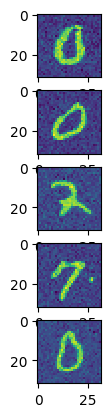

In [5]:
plot(model)

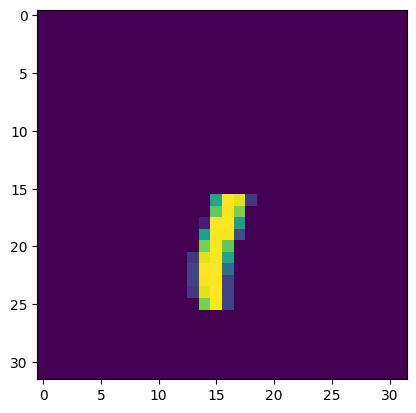

In [6]:
def half_cut(img):
  mask = torch.ones_like(img)
  mask[:, :, :16, :] = 0
  img = img*mask
  return mask, img

for x, y in data_loader:
  mask, x = half_cut(x)
  plt.imshow(x[0][0])
  plt.show()
  break

In [19]:
def plot_with_infill(score_net, x, masks):
  with torch.no_grad():
    samples = sde.infilling_diffusion(score_net, x, mask, data_shape = (32, 1, 32, 32)).detach().cpu().numpy()
  samples = samples.swapaxes(1,2)
  samples = samples.swapaxes(2,3)
  fig, axe = plt.subplots(2, 20)
  for i in range(5):
      axe[0, i].imshow(x[i][0].cpu())
      axe[1, i].imshow(samples[i])
  plt.show()

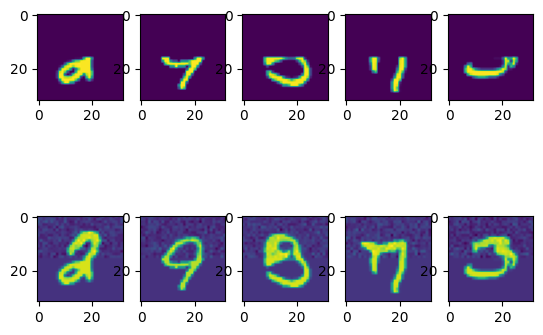

In [20]:
for x, y in data_loader:
  mask, x = half_cut(x)
  x = x.to(device)
  mask = mask.to(device)
  plot_with_infill(model, x, mask)
  break

In [ ]:
torch.nn.functional.one_hot(torch.Tensor([5,5,5,5,5]).to(torch.int64).to(device))

NameError: ignored